In [1]:
# UCIMLRepo: Uncomment the following line to install the package
# !pip3 install -U ucimlrepo 

  Obtaining dependency information for ucimlrepo from https://files.pythonhosted.org/packages/3e/4a/ecc3456479d687202b34ee42317c3a63e09793c9409a720052d38356431a/ucimlrepo-0.0.3-py3-none-any.whl.metadata


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo, list_available_datasets
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score
from sklearn.base import clone
from utilities import check_preprocessed_data

## Dataset and Dataset Info

In [3]:
adult = fetch_ucirepo(name='Adult')
print(adult.metadata.keys())

dict_keys(['uci_id', 'name', 'repository_url', 'data_url', 'abstract', 'area', 'tasks', 'characteristics', 'num_instances', 'num_features', 'feature_types', 'demographics', 'target_col', 'index_col', 'has_missing_values', 'missing_values_symbol', 'year_of_dataset_creation', 'last_updated', 'dataset_doi', 'creators', 'intro_paper', 'additional_info'])


In [4]:
pd.set_option('display.max_columns', None)

print(adult.variables)

              name     role         type      demographic  \
0              age  Feature      Integer              Age   
1        workclass  Feature  Categorical           Income   
2           fnlwgt  Feature      Integer             None   
3        education  Feature  Categorical  Education Level   
4    education-num  Feature      Integer  Education Level   
5   marital-status  Feature  Categorical            Other   
6       occupation  Feature  Categorical            Other   
7     relationship  Feature  Categorical            Other   
8             race  Feature  Categorical             Race   
9              sex  Feature       Binary              Sex   
10    capital-gain  Feature      Integer             None   
11    capital-loss  Feature      Integer             None   
12  hours-per-week  Feature      Integer             None   
13  native-country  Feature  Categorical            Other   
14          income   Target       Binary           Income   

                       

In [5]:
X, y = adult.data.features, adult.data.targets.squeeze()
print(f"Dataset Shape (rows,cols): {X.shape}")
print(f"Target Shape (rows,cols): {y.shape}")

Dataset Shape (rows,cols): (48842, 14)
Target Shape (rows,cols): (48842,)


In [6]:
X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


## Checking Data

In [7]:
# Checking values of the target variable
print(y.value_counts()) # according to the documentation, we should have '<=50K' and '>50K' as the values

# relabelling the target variable to remove the '.' so that they are in the correct classes
y = y.replace({'<=50K.': '<=50K', '>50K.': '>50K'})

income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: count, dtype: int64


In [8]:
# Getting the numerical, binary and categorical feature names
numerical_features = adult.variables[adult.variables['type'] == 'Integer']['name'].tolist()
binary_features = adult.variables[adult.variables['type'] == 'Binary']['name'].tolist()[:-1] # [:-1]removing the target variable from the list
categorical_features = adult.variables[adult.variables['type'] == 'Categorical']['name'].tolist()
# combine categorical and binary features
categorical_features = categorical_features + binary_features

# Checking the unique values of the categorical and binary features
for feature in X.columns:
    if feature in categorical_features:
        print(X[f'{feature}'].value_counts()); print('\n')

workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
?                    1836
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64


education
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: count, dtype: int64


marital-status
Married-civ-spouse       22379
Never-married            16117
Divorced                  6633
Separated                 1530
Widowed                   1518
Married-spouse-absent      628
Married-AF-spouse           37
Name: count, dtype: int64


occupation
Prof-specialty       6172
Craft-repair         6112
Exec-managerial

In [9]:
# check for missing values
print(X.isnull().sum()); print('\n')

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
dtype: int64




In [10]:
# it looks like we have missing values AND missing values represented by '?'
# we will replace the '?' with np.nan
X = X.replace('?', np.nan)

The number of missing values for each of the variables with missingness is small relative to the number of observations in the dataset. Let's just use mean/mode imputation for numerical/categorical variables, respectively. Another option, since the missing values are categorical, is creating a 'Missing' category. This might be interesting since if missingingness is informative of income, then, after one-hot encoding, if our regularized models include the missing feature then we know that missingness for that feature is informative.

## Preprocessor

In [11]:
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore')) # handle_unknown='ignore' will ignore any unknown categories during transform (e.g. Holland-Netherlands only occurs once in the data so it can't be present in the test and train set)
]) # drop='first' drops the first category of all categorical features which helps avoid collinearity; drop='if_binary' will drop the first category of binary features

preprocessor = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_features),
    ('categorical', categorical_pipeline, categorical_features) # recall categorical features contains both categorical and binary features
    ])

In [12]:
X_tmp = X.copy()
X_tmp = preprocessor.fit(X_tmp)
print(X_tmp.transform(X).shape)
transformed_dat = check_preprocessed_data(preprocessor, X, numerical_features, categorical_features)

# Reset the preprocessor to its initial state
preprocessor = clone(preprocessor)

(48842, 97)
Passed: No NaN values found in preprocessed data.
Passed: No infinite values found in preprocessed data.
Passed: No constant columns found in preprocessed data.


# Logistic Regression Models

In [13]:
# PARAMETERS
# Change these RANDOM_STATE_... values from None to the desired values if you want to fix the random state
RANDOM_STATE_SPLIT = None
RANDOM_STATE_MODEL = None
NUM_FOLDS = 5
SCORING = 'f1' # 'accuracy' or 'f1' (there are other options as well, see the documentation)
if SCORING == 'f1':
    SCORING = make_scorer(f1_score, pos_label='>50K') # we are interested in the f1 score for the '>50K' class

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE_SPLIT)

## Logistic Regression with L1 and L2 regularization

In [14]:
# Defining the hyperparameter grid
param_grid = {
    'logistic__C': np.logspace(-3, 3, 10),
    'logistic__penalty': ['l1', 'l2'],
    'logistic__class_weight': [None, 'balanced']
}

# Initialising the logistic regression model
logistic_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('logistic', LogisticRegression(solver='liblinear', random_state=RANDOM_STATE_MODEL)) 
]) # must use saga solver for elasticnet regularization. If not using elasticnet, can use liblinear for l1 and l2 regularization

logistic_pipeline.set_params(logistic__max_iter=1000) # increasing the maximum number of iterations to avoid convergence warning (takes more time to run though)

# Initialising the grid search
logistic_reg_cv = GridSearchCV(logistic_pipeline, param_grid, cv=NUM_FOLDS, scoring=SCORING, n_jobs=-1, verbose=1, error_score='raise')

Fun fact, getting the warning that you are outputting nans can mean that your GridSearchCV is throwing errors since nan is the default output. Add the argument "error_score='raise'" to see if what the error is because by default "error_score=np.nan". Hadn't run into this particular issue before so it took a little to figure out what was going wrong.

In [15]:
# Fitting the model
logistic_reg_cv.fit(X_train, y_train)
cv_results_df = pd.DataFrame(logistic_reg_cv.cv_results_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


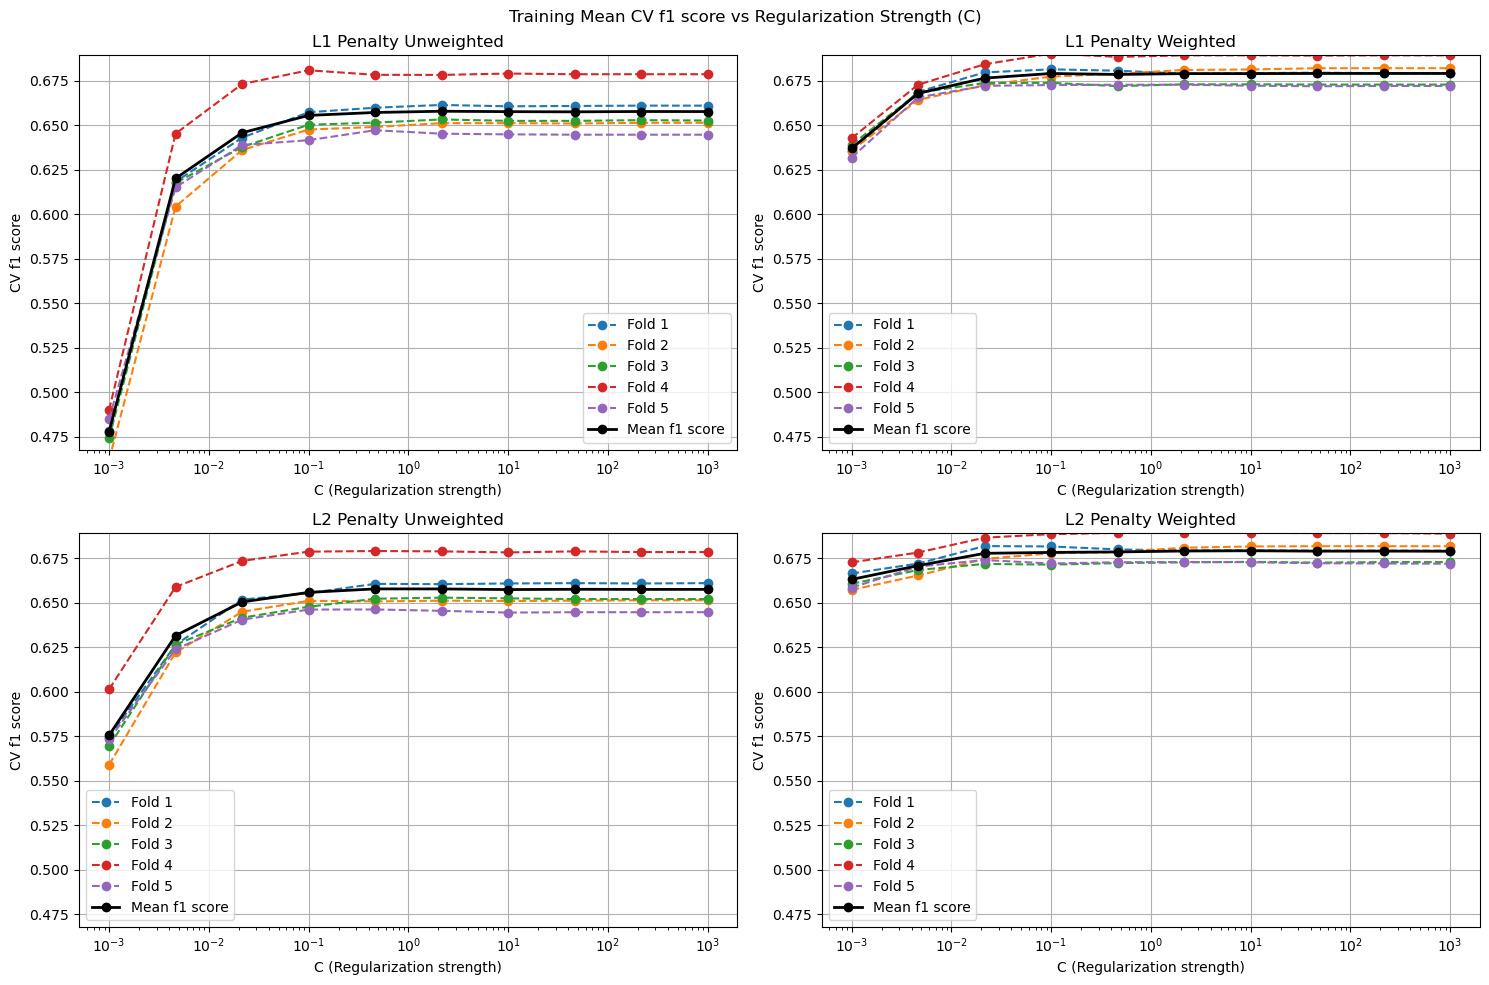

In [16]:
# Global minimum and maximum mean test scores for the plot
global_min_score = cv_results_df['mean_test_score'].min()
global_max_score = cv_results_df['mean_test_score'].max()

# Adding some padding for visual clarity
padding = (global_max_score - global_min_score) * 0.05
global_min_score -= padding
global_max_score += padding

# Set up subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # 2x2 subplot grid

# Title for the whole plot
if SCORING == 'accuracy':
    fig.suptitle('Training Mean CV Accuracy vs Regularization Strength (C)')
else:
    fig.suptitle('Training Mean CV f1 score vs Regularization Strength (C)')

# Define the combinations to plot
combinations = [
    ('l1', None),
    ('l1', 'balanced'),
    ('l2', None),
    ('l2', 'balanced')
]

# Titles for the plots
titles = [
    'L1 Penalty Unweighted',
    'L1 Penalty Weighted',
    'L2 Penalty Unweighted',
    'L2 Penalty Weighted'
]

n_splits = NUM_FOLDS

# Loop through the combinations and axes
for (penalty, class_weight), ax, title in zip(combinations, axes.flatten(), titles):
    # Filter results for the current combination
    mask = ((cv_results_df['param_logistic__penalty'] == penalty) &
            (cv_results_df['param_logistic__class_weight'].astype(str) == str(class_weight)))
    subset_df = cv_results_df[mask]

    # Get list of C values
    C_values = subset_df['param_logistic__C'].astype(float).unique()
    
    # Plot each fold accuracy
    for i in range(n_splits):
        fold_scores = subset_df[f'split{i}_test_score']
        ax.plot(C_values, fold_scores, marker='o', linestyle='--', label=f'Fold {i+1}')

    # Plot mean accuracy
    mean_scores = subset_df['mean_test_score']
    if SCORING == 'accuracy':
        ax.plot(C_values, mean_scores, color='black', marker='o', linestyle='-', linewidth=2, label='Mean accuracy')
    else:
        ax.plot(C_values, mean_scores, color='black', marker='o', linestyle='-', linewidth=2, label='Mean f1 score')

    # setting the y-axis limits to be the same for all plots for easy comparison
    ax.set_ylim(global_min_score, global_max_score)

    # Set plot attributes
    ax.set_title(title)
    ax.set_xlabel('C (Regularization strength)')
    ax.set_xscale('log')  # C values span several orders of magnitude
    if SCORING == 'accuracy':
        ax.set_ylabel('CV Accuracy')
    else:
        ax.set_ylabel('CV f1 score')
    ax.grid(True)
    ax.legend()

plt.tight_layout() # Adjust layout so that titles and labels don't overlap
plt.show()

In [17]:
# Get the best hyperparameters
best_hyperparams = logistic_reg_cv.best_params_
print('Best hyperparameters:')
print(best_hyperparams); print('\n')

# fit the model to the full training set given the best hyperparameters
logistic_pipeline.set_params(**best_hyperparams)
logistic_pipeline.fit(X_train, y_train)


# print training set classification report
print('Training Classification Report')
y_pred_train = logistic_pipeline.predict(X_train)
print(classification_report(y_train, y_pred_train)); print()

# Calculate the confusion matrix, convert to dataframe, and print
confusion = confusion_matrix(y_train, y_pred_train)
confusion_df = pd.DataFrame(confusion, index=['Actual <=50K', 'Actual >50K'], columns=['Predicted <=50K', 'Predicted >50K'])
print('Confusion Matrix')
print(confusion_df)

Best hyperparameters:
{'logistic__C': 10.0, 'logistic__class_weight': 'balanced', 'logistic__penalty': 'l2'}


Training Classification Report
              precision    recall  f1-score   support

       <=50K       0.94      0.80      0.86     29652
        >50K       0.57      0.85      0.68      9421

    accuracy                           0.81     39073
   macro avg       0.76      0.82      0.77     39073
weighted avg       0.85      0.81      0.82     39073


Confusion Matrix
              Predicted <=50K  Predicted >50K
Actual <=50K            23582            6070
Actual >50K              1411            8010


In [18]:
# print testing set classification report
print('Testing Classification Report')
y_pred_test = logistic_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_test))

# Calculate the confusion matrix, convert to dataframe, and print
confusion = confusion_matrix(y_test, y_pred_test)
confusion_df = pd.DataFrame(confusion, index=['Actual <=50K', 'Actual >50K'], columns=['Predicted <=50K', 'Predicted >50K'])
print('Confusion Matrix')
print(confusion_df)

Testing Classification Report
              precision    recall  f1-score   support

       <=50K       0.95      0.79      0.86      7503
        >50K       0.55      0.85      0.67      2266

    accuracy                           0.81      9769
   macro avg       0.75      0.82      0.77      9769
weighted avg       0.86      0.81      0.82      9769

Confusion Matrix
              Predicted <=50K  Predicted >50K
Actual <=50K             5954            1549
Actual >50K               340            1926


## Logistic Regression with ElasticNet Regularization

In [19]:
# Defining the hyperparameter grid for elasticnet regularization
param_grid = {
    'logistic__C': np.logspace(-3, 3, 10),
    'logistic__l1_ratio': np.linspace(0, 1, 5), # l1_ratio = 0 is l2 regularization, l1_ratio = 1 is l1 regularization, and anything in between is elasticnet regularization
    'logistic__class_weight': [None, 'balanced']
}

# Initialising the logistic regression model
logistic_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('logistic', LogisticRegression(penalty='elasticnet', solver='saga', random_state=RANDOM_STATE_MODEL)) 
]) # must use saga solver for elasticnet regularization. If not using elasticnet, can use liblinear for l1 and l2 regularization

logistic_pipeline.set_params(logistic__max_iter=1000) # increasing the maximum number of iterations to avoid convergence warning (takes more time to run though)

# Initialising the grid search
logistic_elasticnet_cv = GridSearchCV(logistic_pipeline, param_grid, cv=NUM_FOLDS, scoring=SCORING, n_jobs=-1, verbose=1, error_score='raise')

In [20]:
# Fitting the model
logistic_elasticnet_cv.fit(X_train, y_train)
cv_results_elasticnet_df = pd.DataFrame(logistic_elasticnet_cv.cv_results_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


e:\anaconda3\envs\predictive_analytics\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


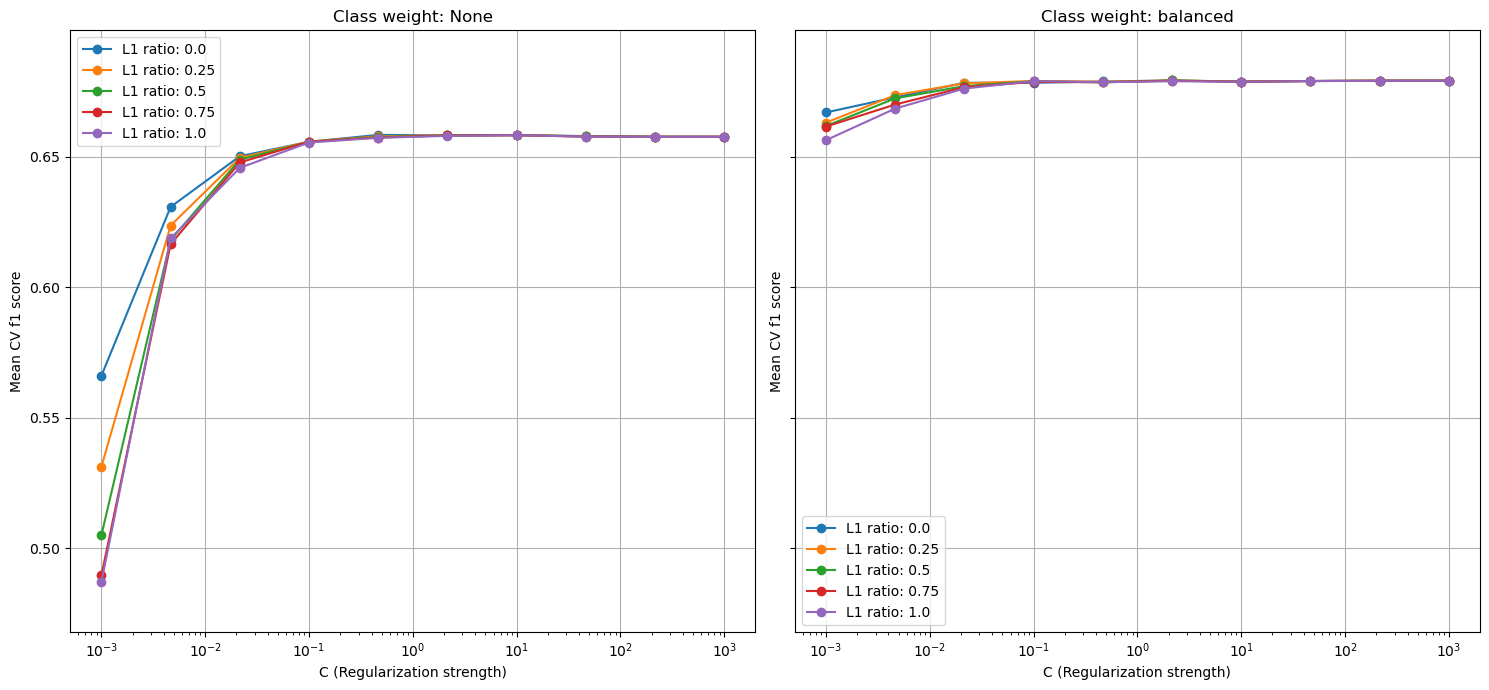

In [21]:
# Define the parameter grid dimensions
C_values = param_grid['logistic__C']
l1_ratios = param_grid['logistic__l1_ratio']
class_weights = param_grid['logistic__class_weight']

# Set up subplots - one subplot for each class weight
fig, axes = plt.subplots(1, len(class_weights), figsize=(15, 7), sharex=True, sharey=True)

# Loop through class weights and plot
for j, class_weight in enumerate(class_weights):
    ax = axes[j]  # Use the j-th axis for the j-th class weight
    
    # Loop through l1_ratios within each class weight
    for i, l1_ratio in enumerate(l1_ratios):
        # Filter results for the current combination of l1_ratio and class_weight
        mask = ((cv_results_elasticnet_df['param_logistic__l1_ratio'] == l1_ratio) &
                (cv_results_elasticnet_df['param_logistic__class_weight'].astype(str) == str(class_weight)))
        subset_df = cv_results_elasticnet_df[mask]
        
        # Plot mean test score against C for the current combination
        ax.plot(subset_df['param_logistic__C'].astype(float), subset_df['mean_test_score'], marker='o', label=f'L1 ratio: {l1_ratio}')
    
    # Set subplot attributes
    ax.set_title(f'Class weight: {class_weight}')
    ax.set_xlabel('C (Regularization strength)')
    if SCORING  == 'accuracy':
        ax.set_ylabel('Mean CV Accuracy')
    else:
        ax.set_ylabel('Mean CV f1 score')
    ax.set_xscale('log')
    ax.grid(True)
    ax.legend()  # Add legend to differentiate l1_ratios

# Find global min and max mean test scores for setting y-axis limits
global_min_score = cv_results_elasticnet_df['mean_test_score'].min()
global_max_score = cv_results_elasticnet_df['mean_test_score'].max()

# Add padding for visual clarity
padding = (global_max_score - global_min_score) * 0.1
global_min_score -= padding
global_max_score += padding

# Set the same y-axis limits for all subplots
for ax in axes:
    ax.set_ylim(global_min_score, global_max_score)

# Adjust layout so that titles and labels don't overlap
plt.tight_layout()
plt.show()

In [22]:
# Get the best hyperparameters
best_hyperparams = logistic_elasticnet_cv.best_params_
print('Best hyperparameters:')
print(best_hyperparams); print('\n')

# fit the model to the full training set given the best hyperparameters
logistic_pipeline.set_params(**best_hyperparams)
logistic_pipeline.fit(X_train, y_train)


# print training set classification report
print('Training Classification Report')
y_pred_train = logistic_pipeline.predict(X_train)
print(classification_report(y_train, y_pred_train)); print()

# Calculate the confusion matrix, convert to dataframe, and print
confusion = confusion_matrix(y_train, y_pred_train)
confusion_df = pd.DataFrame(confusion, index=['Actual <=50K', 'Actual >50K'], columns=['Predicted <=50K', 'Predicted >50K'])
print('Confusion Matrix')
print(confusion_df)

Best hyperparameters:
{'logistic__C': 2.154434690031882, 'logistic__class_weight': 'balanced', 'logistic__l1_ratio': 0.0}




e:\anaconda3\envs\predictive_analytics\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Training Classification Report
              precision    recall  f1-score   support

       <=50K       0.94      0.79      0.86     29652
        >50K       0.57      0.85      0.68      9421

    accuracy                           0.81     39073
   macro avg       0.76      0.82      0.77     39073
weighted avg       0.85      0.81      0.82     39073


Confusion Matrix
              Predicted <=50K  Predicted >50K
Actual <=50K            23567            6085
Actual >50K              1410            8011


In [23]:
# print testing set classification report
print('Testing Classification Report')
y_pred_test = logistic_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_test))

# Calculate the confusion matrix, convert to dataframe, and print
confusion = confusion_matrix(y_test, y_pred_test)
confusion_df = pd.DataFrame(confusion, index=['Actual <=50K', 'Actual >50K'], columns=['Predicted <=50K', 'Predicted >50K'])
print('Confusion Matrix')
print(confusion_df)

Testing Classification Report
              precision    recall  f1-score   support

       <=50K       0.95      0.79      0.86      7503
        >50K       0.55      0.85      0.67      2266

    accuracy                           0.81      9769
   macro avg       0.75      0.82      0.77      9769
weighted avg       0.85      0.81      0.82      9769

Confusion Matrix
              Predicted <=50K  Predicted >50K
Actual <=50K             5953            1550
Actual >50K               341            1925


## Discussions

When fitting the models, setting the '''SCORING''' parameter impacts the resulting best hyperparameters of the grid search. For example, when using accuracy we get models which don't use class weighting for their loss functions. When using f1 score scoring, weighting the loss function to account for class imbalance results in better performance on average in terms of f1 score, but expectedly worse performance on the accuracy metric when comparing to the equivalent model train with accuracy scoring. The scoring metric and class weighting combination we ultimatly choose to use depends on the goal of our classifer. If we just want the highest possible accuacy then using the model which is trained with an accuacy scorer without class weighting might be our choice, but we will see a higher quantity of false negatives (assuming >50K is our positive class). However, if we don't mind making false positives and our primary goal is to maximize true positives, then we using the model trained with f1 score with class weighting might be preferred. 

Anyways, there are many ways that these models may be able to be improved further. Oversampling the minority class, undersampling the majority class, or some combinartion of the two (during training) might improve results on some or all metrics. Additionally, using '''handle_unknown='ignore''' in our one-hot encoder may lead to information loss in categories which are infrequent. Using stratified splits and/or stratified cross validation might be one way to combat this. Furthermore, there may be interaction effects among the input features of the model. If we are interested in these, we can modify the preprocessor to include '''PolynomialFeatures(degree=2, interaction_only=True)''' as a step of our pipeline in order to include these in our model. Note that depending on the initial number of features, this can massively increase the number of parameters that are in the model and not be practical - especially if applied to all features post-one-hot encoding. We could apply it easily to the handlful of numerical predictors however. Lastly, there are plenty of other model types that could be tested against the linear models above, but they won't be included here.